# Imports/Setup

The cell below provides imports all the libraries and packages needed to run this notebook. Additionally, it defines a number of global variables used repeatedly throughout. 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.algorithms import QSVC

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.utils import algorithm_globals

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from scipy.stats import shapiro, normaltest, boxcox
from scipy.special import boxcox1p

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier





fig_count = 0
# !rm ../documents/figures/fig*

figsize_x = 6
figsize_y = 6

algorithm_globals.random_seed = 19
rs = 19

sig = 0.05

# Import Data

The cell below reads in the data:

In [2]:
df = pd.read_csv('../data/creditcard_2023.csv', usecols=lambda column: column != 'id')
df = df.sample(n=20000, random_state=rs)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
464155,-0.482542,0.041680,-0.816092,0.027505,-0.642895,1.205517,0.376225,0.164978,-0.396280,-0.915679,...,0.212968,0.605764,0.949580,-1.040103,-2.641697,0.213101,1.283484,0.896331,20505.35,1
361085,0.334244,0.015699,0.043454,0.719770,-0.204420,0.209583,-0.228739,0.009076,-0.208597,-0.281923,...,0.059503,0.090089,-0.210493,0.706999,1.194518,0.408578,0.541125,0.659595,5876.77,1
221603,1.780507,-0.366932,-0.041555,-0.080264,0.423490,-0.232471,0.667104,-0.240757,0.652274,0.720436,...,-0.086510,0.289082,-0.014990,0.005116,0.665288,-1.204128,-0.255221,-0.255072,12709.56,0
327429,-0.314553,0.392006,-0.632212,0.320638,0.047108,-0.844085,-0.129216,0.107209,0.009878,-0.505409,...,0.186072,0.834611,-0.069152,-0.394446,-0.796567,-0.940515,0.075740,0.397533,7269.92,1
384316,-0.029567,0.237601,-0.089820,0.852088,0.599181,0.434461,0.283549,-0.083801,-0.552274,0.066530,...,0.009567,-0.206203,-0.271387,-1.406612,0.063960,0.801490,-0.020930,-0.093466,5333.59,1


# Dataset Summary

Provide a summary of the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 464155 to 328725
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      20000 non-null  float64
 1   V2      20000 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 2

The output elucidates that `df` contains 568,630 observations of 29 predictor variables (`V1`-`V28`, and `Class`) and one target variable, `Class`.

# Data Evaluation
## Class Imbalance

The cell below compares the observations in each class using histograms:

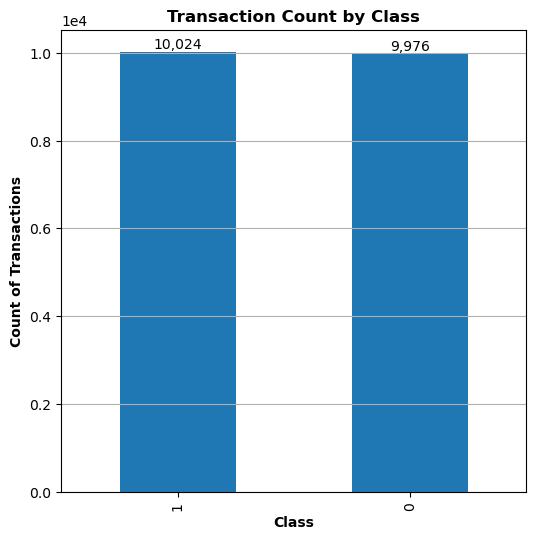

In [4]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

class_counts = df['Class'].value_counts()

class_counts.plot(kind='bar')  # or use 'hist' for a histogram

for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.1, f'{value:,}', ha='center', va='bottom')
    
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count of Transactions',fontweight='bold')
plt.title('Transaction Count by Class', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(axis='y')
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

To make the dataset more realistic, the cell below drops drop positive (A.K.A fraudulent, 1) observations until they only make up 1% of the entire dataset. Removals are done at random.

In [5]:
fraud_prop = 0.01
fraud_size = int((fraud_prop * class_counts[0]) / (1 - fraud_prop))
num_removals = class_counts[1] - fraud_size

condition = df['Class'] == 1
rows_to_remove = df[condition].sample(n=num_removals, random_state=rs)
df = df.drop(rows_to_remove.index)

The plot below checks to ensure an appropriate number of observations have been removed:

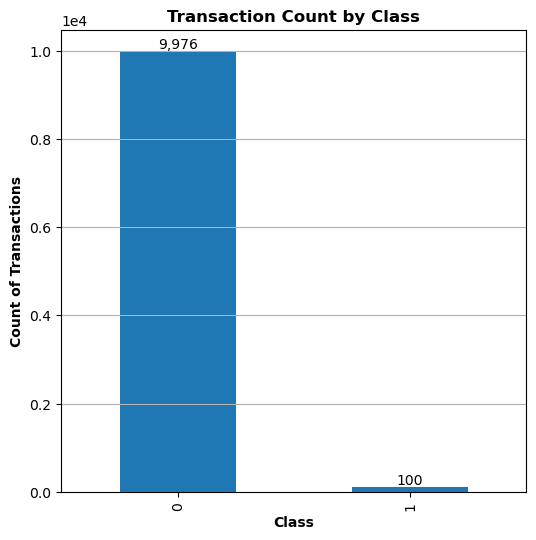

In [6]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

class_counts = df['Class'].value_counts()

class_counts.plot(kind='bar')  # or use 'hist' for a histogram

for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.1, f'{value:,}', ha='center', va='bottom')
    
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count of Transactions',fontweight='bold')
plt.title('Transaction Count by Class', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(axis='y')
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

Before moving onto the next section, the cell below splits `df` into two new dataframes: 

* `df_X`: Contains only the predictors present in `df`.
* `df_y`: Contains only the target variable in `df`: `Class`.

In [7]:
df_X = df.drop(['Class'], axis=1)
df_y = df['Class']

## Outliers

Evaluating the presence of outliers is crucial to deciding the data pre-processing steps required for modelling. The cell below creates function that identifies the outliers in each column of a dataframe. 

In [8]:
def identify_outliers(df):
    outlier_rows = []
    for column in df.select_dtypes(include='number'):  # Only process numeric columns
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        for i, value in enumerate(df[column].values):
            if value < lower_bound or value > upper_bound:
                outlier_rows.append([column, i, value])
            
    # Get unique rows with at least one outlier
    return pd.DataFrame(outlier_rows, columns = ['column_name', 'row_num', 'value'])

The `identify_outliers` function is used below to identify all outliers in `df`:

In [9]:
outlier_df = identify_outliers(df_X)
outlier_df = (
    outlier_df[['column_name', 'row_num']]
    .groupby(by='column_name').count()
    .sort_values(by='row_num')
    .reset_index()
)
outlier_df.columns = ['column_name', 'num_outliers']

The data contained within `outlier_df` is presented in the plot below:

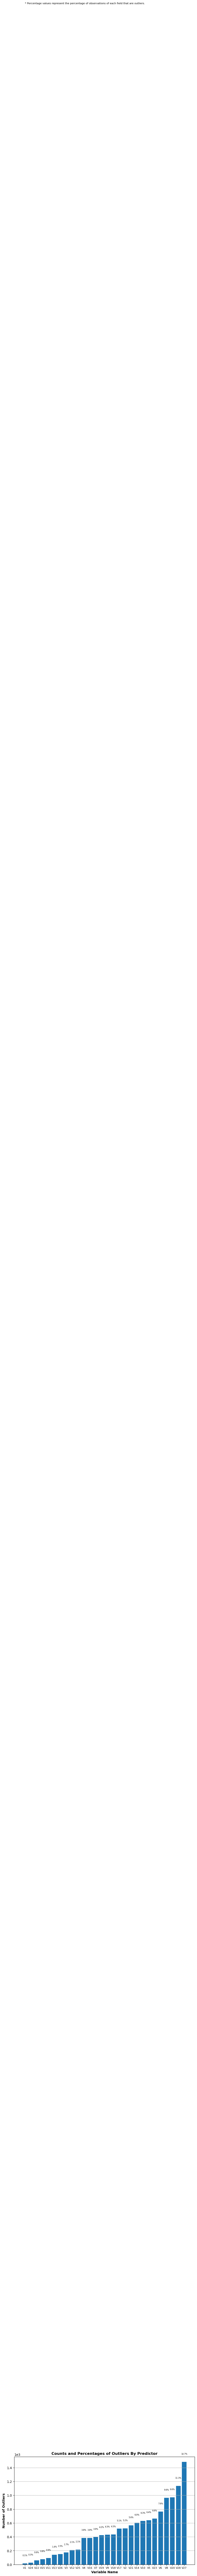

In [10]:
fig_count += 1
plt.figure(figsize=(10,6))

plt.bar(outlier_df['column_name'], outlier_df['num_outliers'])

for i, value in enumerate(outlier_df['num_outliers'].values):
    perc_outlier = (value / df.shape[0]) * 100
    plt.text(i, value + 100, f'{perc_outlier:.1f}%', ha='center', va='bottom', fontsize=6)
    
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Number of Outliers',fontweight='bold')
plt.title('Counts and Percentages of Outliers By Predictor', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.text(0, 37000, '* Percentage values represent the percentage of observations of each field that are outliers.', fontsize=8)

plt.grid(axis='y')
# #plt.savefig(f'../documents/figures/fig_{fig_count}.png')
# plt.show()

Clearly, the dataframe contains a reasonable number of outliers in many of the fields. This will be one of the primary considerations when choosing the data pre-processing steps in the next section. 

## Distributions

The shape of the distributions of each predictor is another consideration when determining the appropriate data pre-processing steps. They are plotted below using a boxplot:

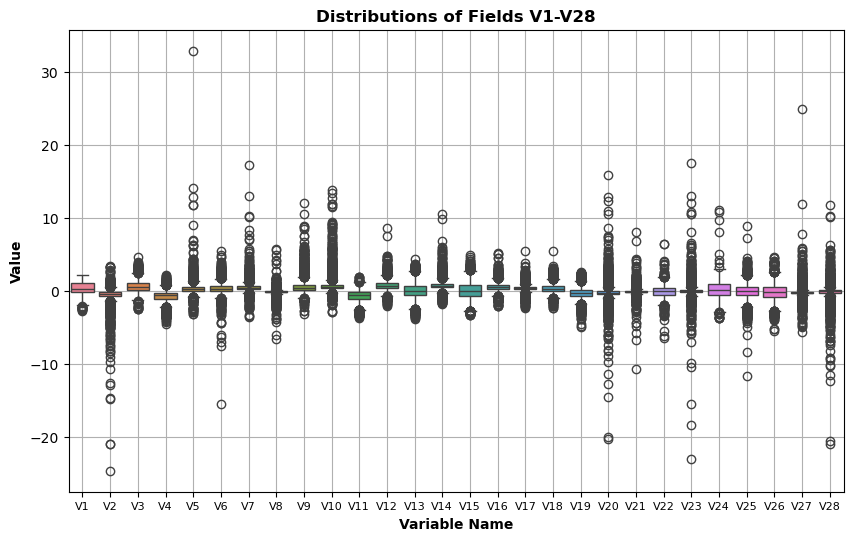

In [11]:
fig_count += 1
plt.figure(figsize=(10,6))
plt_df = df.drop(['Class', 'Amount'], axis=1)

sns.boxplot(data=plt_df)
plt.grid()
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Distributions of Fields V1-V28', fontweight='bold')
plt.tick_params(axis='x', which='major', labelsize=8)
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

The many outliers make the distributions hard to see, but they can also be evaluated quantitatively to determine their shape. For instance, the cell below defines a function `evaluate_normality` that determines if each predictor variable exhibits a normal distribution using `scipy`'s `normaltest`:

In [12]:
def evaluate_normality(df):
    results = []
    for column in df.columns:
        stat, p = normaltest(df[column])
        normal = p > 0.05
        results.append([column, stat, p, normal])
                       

    return pd.DataFrame(results, columns = ['variable_name', 'statistic', 'p_value', 'normal'])

In [13]:
evaluate_normality(df_X)

,variable_name,statistic,p_value,normal
0,V1,1157.735693,3.989225e-252,False
1,V2,17106.343940,0.000000e+00,False
2,V3,802.362869,5.876472e-175,False
3,V4,748.163496,3.454309e-163,False
4,V5,18854.827665,0.000000e+00,False
5,V6,3210.073620,0.000000e+00,False
6,V7,15174.408088,0.000000e+00,False
7,V8,5232.219671,0.000000e+00,False
8,V9,6360.363696,0.000000e+00,False
9,V10,13028.538297,0.000000e+00,False


The output above makes clear that none of the predictor variables can be considered to have a normal distribution. 

## Multicollinearity

The last aspect of the data taken into consideration before apply any pre-processing transformation is its multicollinearity. The cell below produces a correlation matrix of all the predictor fields, which checks the correlation of all pairs of predictors.

V9


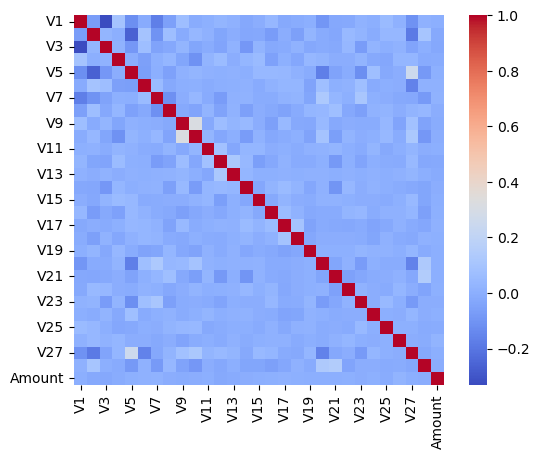

In [14]:
correlation_matrix = df_X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", square=True)
print(max(correlation_matrix))

The minimum and maximum correlation values are also displayed below: 

In [15]:
correlation_matrix = correlation_matrix.replace(1, 0)

max_corr_value = correlation_matrix.select_dtypes(include='number').max().max()
min_corr_value = correlation_matrix.select_dtypes(include='number').min().min()

print(f'Minimum correlation value: {min_corr_value}')
print(f'Maximum correlation value: {max_corr_value}')

Minimum correlation value: -0.33018998359346213
Maximum correlation value: 0.3144560064022087


The output above coupled with the results of the correlation matrix provide strong evidence that no pair of predictor variables maintain a troublesome degree of correlation. 

# Data Pre-Processing

Based on the results of the previous section, there are two facets of the data that need to be addressed:

1. A large number of outliers present within many predictors.
2. Non-normal distributions for all predictors. 

There is no reason to believe the outliers are due to error, and should likely continue to be included in the dataset. However, given their quantity and scale, these outliers can have their influence limited by applying Winsorization, in which outliers are "pulled in" by capping extreme values to a specified percentile range. 

To address the non-normal (skewed) distributions of the predictors, we can perform a power transformation that will have the effect of smoothing the variance over the range of the distribution (reducing heteroscedasticity). This kind of transformation typically supports normalization. Box-Cox and Yeo-Johnson transformations are the most common approaches, but the latter will be applied in this case since the former only works for values $>0$. 

To prevent data leakage, these transformations will be fitted exclusively on a training dataset, and the resultant parameters will then be applied to transform the data.

First the cell below splits the data into testing and training matrices:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_X.values, df_y.values, test_size=0.25, random_state=rs)

Next, the cell below defines a function that can apply the windsorization transformation:

In [17]:
def apply_winsorization(train_matrix, test_matrix, limits=(0.05, 0.95)):
    """
    Apply Winsorization to all columns in training and test matrices.

    Args:
        train_matrix (np.ndarray): Training data matrix.
        test_matrix (np.ndarray): Test data matrix.
        limits (tuple): Quantile limits for Winsorization (default is (0.05, 0.95)).

    Returns:
        np.ndarray, np.ndarray: Transformed training and test matrices.
    """
    train_matrix = train_matrix.copy()
    test_matrix = test_matrix.copy()

    for col in range(train_matrix.shape[1]):  # Loop over all columns
        lower, upper = np.quantile(train_matrix[:, col], limits)
        train_matrix[:, col] = np.clip(train_matrix[:, col], lower, upper)
        test_matrix[:, col] = np.clip(test_matrix[:, col], lower, upper)
    
    return train_matrix, test_matrix

The training and testing data are transformed below using the `apply_windsorization` function:

In [18]:
X_train, X_test = apply_winsorization(X_train, X_test)

Next, the cell below applies the Yeo-Johnson transformation:

In [19]:
yj = PowerTransformer(method='yeo-johnson')

X_train = yj.fit_transform(X_train)
X_test = yj.transform(X_test)

In [20]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
df_X_pp = pd.DataFrame(np.vstack((X_train, X_test)), columns=df_X.columns)
df_y_pp = pd.Series(np.concatenate([y_train, y_test]), name=df_y.name)
df_pp = pd.concat([df_X_pp, df_y_pp], axis=1)

The result of the scaling is shown in the following plot: 

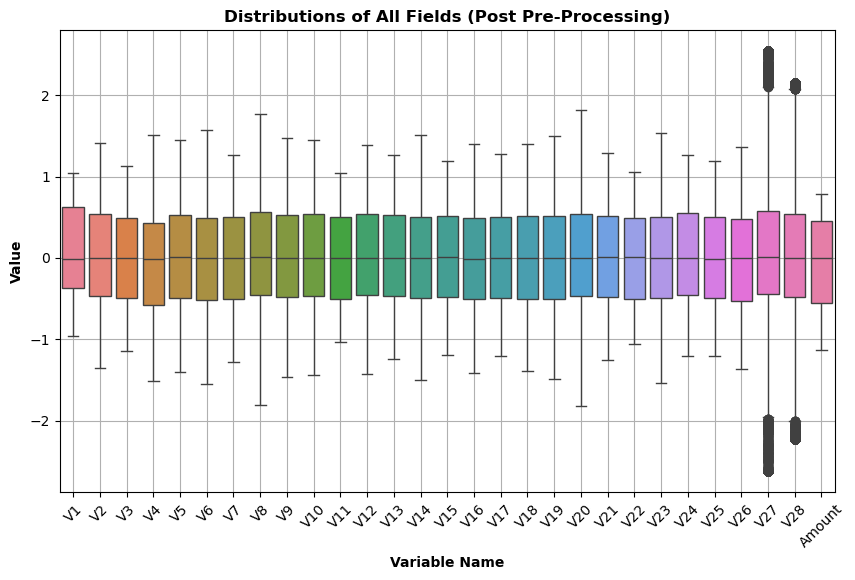

In [22]:
fig_count += 1

plt.figure(figsize=(10,6))

sns.boxplot(data=df_X_pp)
plt.grid()
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Distributions of All Fields (Post Pre-Processing)', fontweight='bold')
plt.xticks(rotation=45)
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

In [23]:
outlier_df = identify_outliers(df_X_pp)
outlier_df = (
    outlier_df[['column_name', 'row_num']]
    .groupby(by='column_name').count()
    .sort_values(by='row_num')
    .reset_index()
)
outlier_df.columns = ['column_name', 'num_outliers']
outlier_df

,column_name,num_outliers
0,V28,1177
1,V27,1448


In [24]:
evaluate_normality(df_X_pp)

,variable_name,statistic,p_value,normal
0,V1,19715.773868,0.000000e+00,False
1,V2,276.944187,7.283394e-61,False
2,V3,1548.336116,0.000000e+00,False
3,V4,151.092411,1.551314e-33,False
4,V5,267.131794,9.841652e-59,False
5,V6,111.376359,6.530267e-25,False
6,V7,632.317013,4.944305e-138,False
7,V8,7.587345,2.251277e-02,False
8,V9,247.471659,1.828993e-54,False
9,V10,281.693452,6.777104e-62,False


# Exploratory Data Analysis

The cell below evaluates which predictors might be most important to the model by performing $t$-tests of the means of each predictor variable separated by class. 

In [25]:
df_class0 = df_pp[df_pp['Class'] == 0]
df_class1 = df_pp[df_pp['Class'] == 1]

p_vals = []
for col in df_X.columns:
    
    group1 = df_class0[col]
    group2 = df_class1[col]
    
    t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    
    p_vals.append(p_value)

The results of these t-tests can be visualized below:

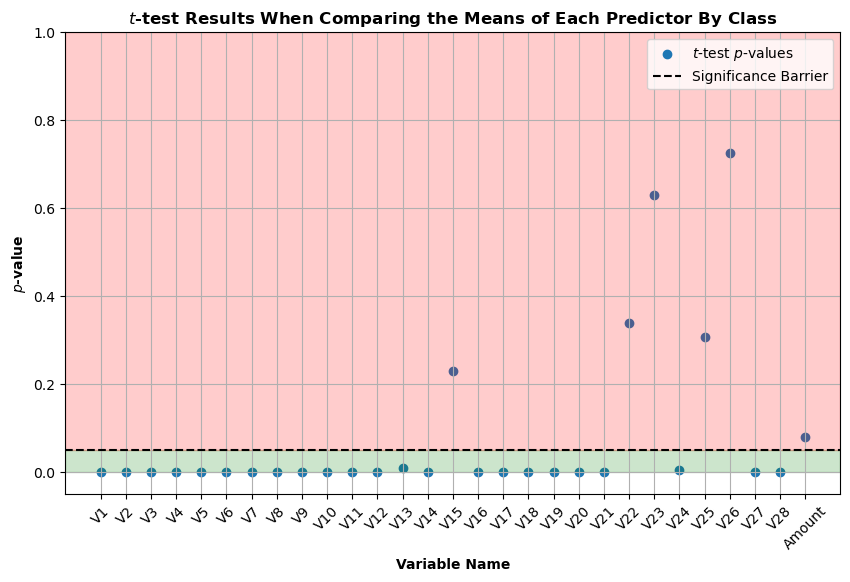

In [26]:
fig_count += 1
plt.figure(figsize=(10, figsize_y))

xs = np.arange(0,len(p_vals))
plt.scatter(xs, p_vals, label='$t$-test $p$-values')
plt.axhline(sig, color='black', ls='--', label='Significance Barrier')
plt.axhspan(0, sig, color='green', alpha=0.2)
plt.axhspan(sig, 1, color='red', alpha=0.2)
plt.xticks(xs, df_X.columns)
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('$p$-value', fontweight='bold')
plt.title('$t$-test Results When Comparing the Means of Each Predictor By Class', fontweight='bold')
plt.ylim(-0.05,1)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

Most of the variables exhibit statistically significant differences when comparing the means of the observations in each class. The cells below provide histograms of two of these predictors as examples, highlighting the difference in distribution when split by class. 

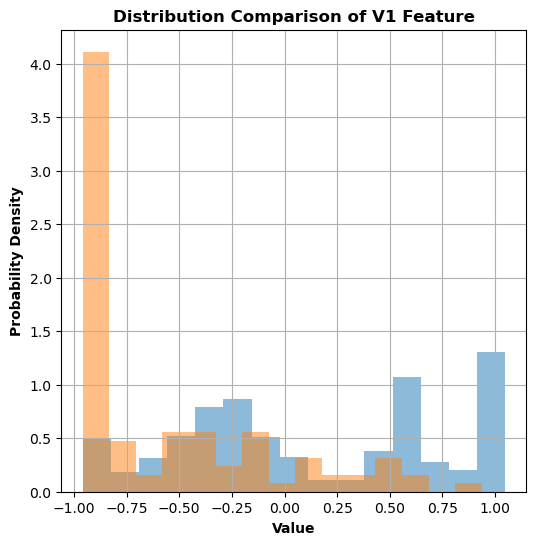

In [27]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

group1 = df_class0['V1']
group2 = df_class1['V1']

plt.hist(group1, bins=15, alpha=0.5, density=True, label='Class 0')
plt.hist(group2, bins=15, alpha=0.5, density=True, label='Class 1')

plt.title('Distribution Comparison of V1 Feature', fontweight='bold')
plt.grid()
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Probability Density', fontweight='bold')
#plt.savefig(f'../documents/figures/fig_{fig_count}.png')
plt.show()

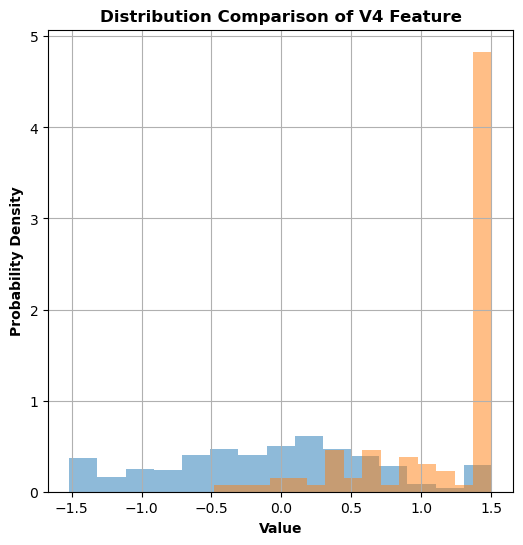

In [28]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

group1 = df_class0['V4']
group2 = df_class1['V4']

plt.hist(group1, bins=15, alpha=0.5, density=True, label='Class 0')
plt.hist(group2, bins=15, alpha=0.5, density=True, label='Class 1')

plt.title('Distribution Comparison of V4 Feature', fontweight='bold')
plt.grid()
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Probability Density', fontweight='bold')
plt.show()

# Classical Machine Learning 


In [38]:
svm = SVC(class_weight='balanced', random_state=rs) 

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Perform grid search
scoring_fcn = make_scorer(f1_score, pos_label=1)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring=scoring_fcn, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and evaluate on the test set
print("Best Parameters:", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.7s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.1, gamma=0.1

In [39]:
rf = RandomForestClassifier(class_weight='balanced', random_state=rs)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=scoring_fcn, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and evaluate on the test set
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_

# Quantum Algorithm Evaluation


In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1, entanglement="linear")

sampler = StatevectorSampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [ ]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(X_train, y_train) 

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")